In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring
import wrangle as w
import explore as ex
import evaluate

# Python without these is hard
import pandas as pd
import numpy as np
from pydataset import data
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.impute import SimpleImputer
# Regression Modeling
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph

In [2]:
# w.get_zillow_data(cached=False) 

In [3]:
df = w.wrangle_zillow()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36592 entries, 14634203 to 10713993
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathrooms       36592 non-null  float64
 1   bedrooms        36592 non-null  float64
 2   square_feet     36592 non-null  float64
 3   latitude        36592 non-null  float64
 4   longitude       36592 non-null  float64
 5   year_built      36592 non-null  int64  
 6   tax_value       36592 non-null  float64
 7   age_of_home     36592 non-null  int64  
 8   beds_and_baths  36592 non-null  float64
 9   beds_per_sqft   36592 non-null  float64
 10  baths_per_sqft  36592 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 3.4 MB


# Exploration

In [5]:
target = 'tax_value'

In [6]:
w.select_kbest(df, target, 7)

['bathrooms',
 'bedrooms',
 'square_feet',
 'year_built',
 'age_of_home',
 'beds_and_baths',
 'beds_per_sqft']

In [7]:
w.rfe(df,target,7)

['bathrooms',
 'bedrooms',
 'square_feet',
 'year_built',
 'age_of_home',
 'beds_and_baths',
 'baths_per_sqft']

In [8]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.train_validate_test_split(df, target, 42)

In [9]:
train.shape, validate.shape, test.shape

((20491, 11), (8782, 11), (7319, 11))

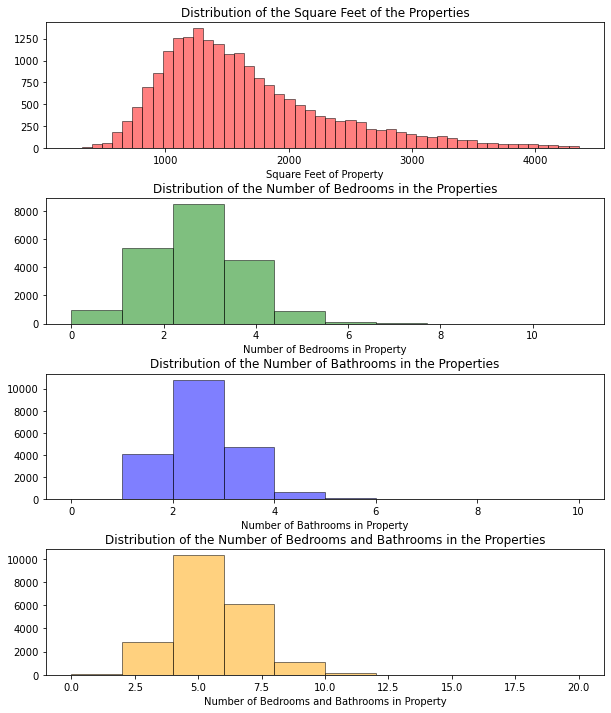

In [10]:
plt.figure(figsize=(10,12))

plt.subplot(4, 1, 1, xlabel='Square Feet of Property', title='Distribution of the Square Feet of the Properties')
plt.hist(data=train, x='square_feet', bins=50, color='red', alpha=.5, ec='black')

plt.subplot(4, 1, 2, xlabel='Number of Bedrooms in Property', title='Distribution of the Number of Bedrooms in the Properties')
plt.hist(data=train, x='bedrooms', color='green', alpha=.5, ec='black')

plt.subplot(4, 1, 3, xlabel='Number of Bathrooms in Property', title='Distribution of the Number of Bathrooms in the Properties')
plt.hist(data=train, x='bathrooms', color='blue', alpha=.5, ec='black')

plt.subplot(4, 1, 4, xlabel='Number of Bedrooms and Bathrooms in Property', title='Distribution of the Number of Bedrooms and Bathrooms in the Properties')
plt.hist(data=train, x='beds_and_baths', color='orange', alpha=.5, ec='black')


plt.subplots_adjust(hspace=.4)

plt.show()


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20491 entries, 12545738 to 11235438
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathrooms       20491 non-null  float64
 1   bedrooms        20491 non-null  float64
 2   square_feet     20491 non-null  float64
 3   latitude        20491 non-null  float64
 4   longitude       20491 non-null  float64
 5   year_built      20491 non-null  int64  
 6   tax_value       20491 non-null  float64
 7   age_of_home     20491 non-null  int64  
 8   beds_and_baths  20491 non-null  float64
 9   beds_per_sqft   20491 non-null  float64
 10  baths_per_sqft  20491 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 1.9 MB


# Scale the data

In [12]:
object_cols = w.get_object_cols(train)
object_cols

[]

In [13]:
numeric_cols = w.get_numeric_X_cols(X_train, object_cols)
numeric_cols

['bathrooms',
 'bedrooms',
 'square_feet',
 'latitude',
 'longitude',
 'year_built',
 'age_of_home',
 'beds_and_baths',
 'beds_per_sqft',
 'baths_per_sqft']

In [14]:
X_train_scaled, X_validate_scaled, X_test_scaled = w.min_max_scale(X_train, X_validate, X_test, numeric_cols)

# Statisical Tests

### Overview of Statistical Tests

- Correlation tests are used to check if two samples are related. They are often used for feature selection and multivariate analysis in data preprocessing and exploration.

- A T-test lets us compare a categorical and a continuous variable by comparing the mean of the continuous variable by subgroups based on the categorical variable

All statistical testing will be run using a 95% confidence level, making the alpha value 5% or 0.05. If the p-value is less than the alpha value we can reject the null hypothesis (H<sub>0</sub>) and move forward with the alternate hypothesis (H<sub>1</sub>).


### Hypotheses

For all Correlation tests below: 

- The H<sub>0</sub> is that there is no correlation between the two samples.

- The H<sub>1</sub> is that there is a correlation between the two samples.

For the T-test:

- The H<sub>0</sub> is that there is no difference in the means of the LA County Tax rates.
- The H<sub>1</sub> is that the LA County Tax Rate is a different mean than the entire population.

Because of the T-test hypothesis, I will be conducting a 1 sample T-test.

In [15]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [16]:
r, p = stats.pearsonr(X_train.bathrooms, y_train.tax_value)
round(r,4), round(p, 10)

(0.4431, 0.0)

In [17]:
r, p = stats.pearsonr(X_train.bedrooms, y_train.tax_value)
round(r,4), round(p, 10)

(0.259, 0.0)

In [18]:
r, p = stats.pearsonr(X_train.square_feet, y_train.tax_value)
round(r,4), round(p, 10)

(0.5296, 0.0)

In [19]:
r, p = stats.pearsonr(X_train.beds_and_baths, y_train.tax_value)
round(r,4), round(p, 10)

(0.3871, 0.0)

In [20]:
r, p = stats.pearsonr(X_train.beds_per_sqft, y_train.tax_value)
round(r,4), round(p, 10)

(-0.3647, 0.0)

In [21]:
r, p = stats.pearsonr(X_train.baths_per_sqft, y_train.tax_value)
round(r,4), round(p, 10)

(-0.1527, 0.0)

### Results of Statistical Testing

Correlation results between the following features:
- bathrooms and tax value: t-statistic = 0.3998, p-value = 0.0
- bedrooms and tax value: t-statistic = 0.2363, p-value = 0.0
- square feet and tax value: t-statistic = 0.4752, p-value = 0.0
- total number of bedrooms and bathrooms and tax value: t-statistic = 0.3497, p-value = 0.0
- bathrooms and square feet: t-statistic = 0.7379, p-value = 0.0

All correlation tests reject the H<sub>0</sub> and can move forward with the corresponding H<sub>1</sub>.


One Sample T-test results are as follows:

- The t-statistic = 56.7063, and the p-value = 0.0.

There is enough evidence to reject the H<sub>0</sub> and move forward with the H<sub>1</sub> indicating that the LA country tax rate mean is significantly different from the tax rate of all 3 counties.

# Modeling

## Baseline

In [23]:
value_pred_mean = y_train.tax_value.mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

value_pred_median = y_train.tax_value.median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

In [24]:
# RMSE of value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_mean) ** (1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_mean) ** (1/2)

# Storing mean baseline values
rmse_train_baseline_mean = rmse_train
rmse_validate_baseline_mean = rmse_validate

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_median) ** (1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_median) ** (1/2)

# Storing median baseline values
rmse_train_baseline_median = rmse_train
rmse_validate_baseline_median = rmse_validate

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  271194.48 
Validate/Out-of-Sample:  272149.78
RMSE using Median
Train/In-Sample:  276269.48 
Validate/Out-of-Sample:  277446.89


### Baseline Model R<sup>2</sup> Value

In [25]:
r2_score_baseline = r2_score(y_validate.tax_value, y_validate.value_pred_mean)
r2_score_baseline

-2.145577268075627e-05

## Linear Regression (OLS)

In [26]:
lm = LinearRegression(normalize=True)


lm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm) ** (1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

RMSE for OLS using LinearRegression
Training/In-Sample:  217503.9051 
Validation/Out-of-Sample:  220468.9564


### OLS Model R<sup>2</sup> Value

In [27]:
r2_score_ols = r2_score(y_validate.tax_value, y_validate.value_pred_lm)
round(r2_score_ols, 4)

0.3437

## TweedieRegressor (GLM)

In [28]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm) ** (1/2)

# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train,4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  217516.6069 
Validation/Out-of-Sample:  220563.6468


### Tweedie Regressor Model R<sup>2</sup> Value

In [29]:
r2_score_glm = r2_score(y_validate.tax_value, y_validate.value_pred_glm)
round(r2_score_glm, 4)

0.3432

## LassoLars

In [30]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lars) ** (1/2)

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,4))

RMSE for Lasso + Lars
Training/In-Sample:  217521.8752 
Validation/Out-of-Sample:  220536.3882


### Lasso Lars Model R<sup>2</sup> Value

In [31]:
r2_score_lars = r2_score(y_validate.tax_value, y_validate.value_pred_lars)
round(r2_score_lars,4)

0.3433

## Polynomial Regression

In [32]:
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

### LinearRegression

In [33]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! c
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2) ** (1/2)

# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train,4), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,4))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  211227.5585 
Validation/Out-of-Sample:  214109.6968


### Polynomial Regession Model R<sup>2</sup> Value

In [34]:
r2_score_lm2 = r2_score(y_validate.tax_value, y_validate.value_pred_lm2)
round(r2_score_lm2, 4)

0.381

## Polynomial Regression Model Test

In [35]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.value_pred_lm2) ** (1/2)

print("RMSE for LassoLars Model\nOut-of-Sample Performance: ", round(rmse_test, 4))

RMSE for LassoLars Model
Out-of-Sample Performance:  213615.6212


In [36]:
print(f'Baseline Performance:\nRSME mean: {round(rmse_train_baseline_mean, 3)}\nRSME median: {round(rmse_train_baseline_median,3)}\n')


print("RMSE for Polynomial Regression Train and Validate Performance:\nTraining/In-Sample: ", round(rmse_train,3), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,3), '\n')

print("RMSE for Polynomial Regression Model Test Performance:\nOut-of-Sample Performance: ", rmse_test)
print(f'The Linear Regession model has an R_squared of {round(r2_score_lm2, 3)}')

Baseline Performance:
RSME mean: 271194.48
RSME median: 276269.481

RMSE for Polynomial Regression Train and Validate Performance:
Training/In-Sample:  211227.558 
Validation/Out-of-Sample:  214109.697 

RMSE for Polynomial Regression Model Test Performance:
Out-of-Sample Performance:  213615.6212365427
The Linear Regession model has an R_squared of 0.381


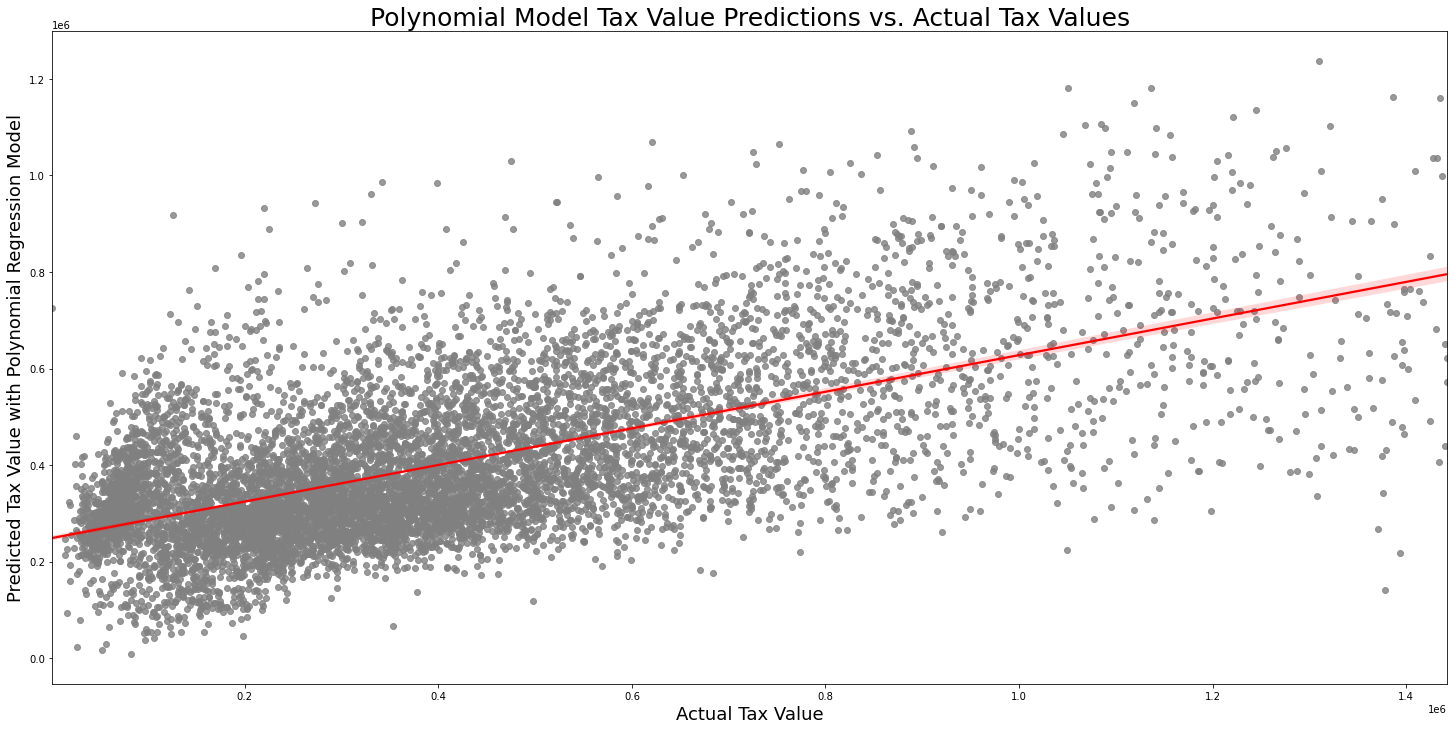

In [37]:
plt.figure(figsize=(25,12))

sns.regplot(data=y_test, x=y_validate.tax_value, y=y_validate.value_pred_lm2, 
            scatter_kws={'color':'grey'}, line_kws={'color':'red'})

plt.title('Polynomial Model Tax Value Predictions vs. Actual Tax Values', fontdict={'fontsize':25})
plt.xlabel("Actual Tax Value", fontdict={'fontsize':18})
plt.ylabel("Predicted Tax Value with Polynomial Regression Model", fontdict={'fontsize':18})
plt.savefig('poly_actual_pred')

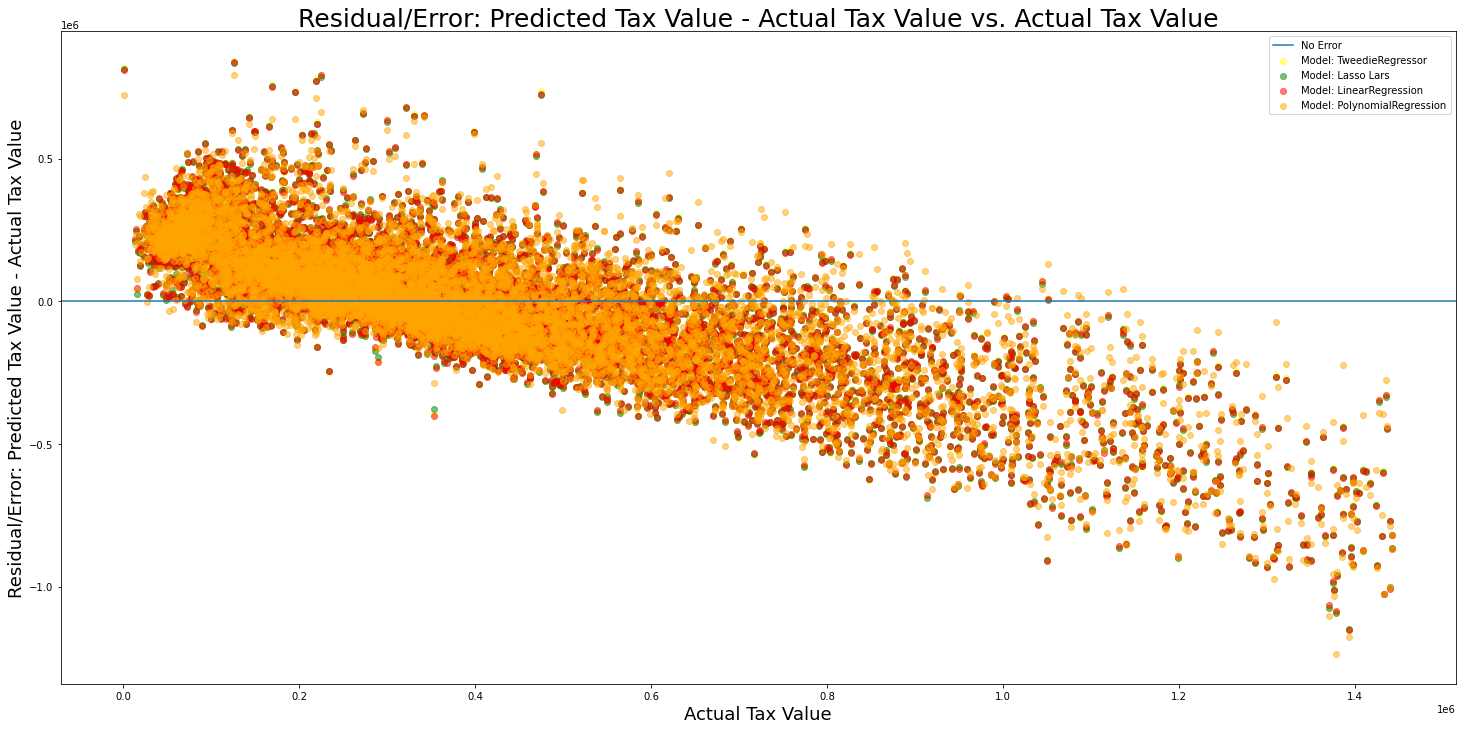

In [38]:
plt.figure(figsize=(25,12))

plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=None, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lars - y_validate.tax_value, 
            alpha=.5, color="green", s=None, label="Model: Lasso Lars")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=None, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lm2 - y_validate.tax_value , 
            alpha=.5, color="orange", s=None, label="Model: PolynomialRegression")
plt.legend()
plt.xlabel("Actual Tax Value", fontdict={'fontsize':18})
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value", fontdict={'fontsize':18})
plt.title("Residual/Error: Predicted Tax Value - Actual Tax Value vs. Actual Tax Value", fontdict={'fontsize':25})

plt.savefig('poly_resid_actual')
plt.show()

In [39]:
y_validate.to_csv('y_validate.csv')

# Tax Rate distribution

In [ ]:
tax_df = w.tax_rate_distribution()

In [ ]:
tax_df.info()

In [ ]:
tax_df.groupby('fips').mean()

In [ ]:
sns.set_style('darkgrid')

plt.hist(data=tax_df, x='tax_value', bins=100, color='red', alpha=.5, ec='black', label='Tax Value Distribution of 3 Southern Californian Counties')

plt.show()

In [ ]:
sns.set_style('darkgrid')

plt.hist(data=tax_df, x='tax_rate', bins=100, color='red', alpha=.5, ec='black', label='Tax Value Distribution of 3 Southern Californian Counties')

plt.show()

In [ ]:
la_county = tax_df[tax_df.fips == 6037]

In [22]:
t, p = stats.ttest_1samp(la_county.tax_rate, tax_df.tax_rate.mean())
round(t,4), round(p, 10)

NameError: name 'la_county' is not defined

In [ ]:

plt.figure(figsize=(25,12))

plt.hist(data=tax_df[tax_df.fips == 6037], x='tax_rate', bins=100, color='red', alpha=.5, ec='black', label='Los Angeles County')
plt.hist(data=tax_df[tax_df.fips == 6059], x='tax_rate',  bins=100, color='green', alpha=.5, ec='black', label='Orange County')
plt.hist(data=tax_df[tax_df.fips == 6111], x='tax_rate', bins=100, color="blue", alpha=.5, ec='black', label='Ventura County')

plt.title('Tax Rate Distributions of 3 Southern Californian Counties', fontdict={'fontsize':25})
plt.legend()
plt.savefig('tax_rate_all')

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3, 1, 1, xlabel='Tax Rate', title='Tax Rate Distribution of Los Angeles County, California')
plt.hist(data=tax_df[tax_df.fips == 6037], x='tax_rate', bins=100, color='red', alpha=.5, ec='black')

plt.subplot(3, 1, 2, xlabel='Tax Rate', title='Tax Rate Distribution of Orange County, California')
plt.hist(data=tax_df[tax_df.fips == 6059], x='tax_rate',  bins=100, color='green', alpha=.5, ec='black')

plt.subplot(3, 1, 3, xlabel='Tax Rate', title='Tax Rate Distribution of Ventura County, California')
plt.hist(data=tax_df[tax_df.fips == 6111], x='tax_rate', bins=100, color="blue", alpha=.5, ec='black')

plt.subplots_adjust(hspace=.4)
plt.show()


In [ ]:
tax_df.to_csv('tax_rate.csv')

# Conclusion

It is clear that square feet and number of bathrooms are good drivers of the property value within this dataset.

However, with over 60 features, the majority of them are useless due to the lack of data included.

I managed to create a model that out performs the baseline model by lowering the RMSE by 58,534 points from 272,150 to 213,616. This model also fits the data with an R<sup>2</sup> value of 38.1%. 

What can we do now?

- Collect, or more accurately, fill in more of the data on these properties in order to strengthen the model.
- In this case less can be more. 
- Breakup the data into commercial and residential, along with the features associated with each zone.

With additional time dedicated to this project:
- I would like to explore the longitude and latitude effect on the propery value
- If more data was filled in to this dataset, I would like to explore features like the air conditioning type and lot size.

In [ ]:
df = w.get_zillow_data(cached=True)

In [ ]:
features = 

In [ ]:
sns.scatterplot(data=train, x=train.longitude, y=train.latitude)

In [ ]:
plt.figure(figsize=(14,10))


sns.jointplot(data = train, 
              x = 'tax_value', 
              y = 'latitude', 
              kind = 'kde', 
              cmap = 'Greens',
              fill = True)


plt.ylabel('South', loc='bottom')
plt.ylabel('Latitude', loc='center')
plt.ylabel('North', loc='top') 


plt.show()

sns.jointplot(data = train, 
              x = 'square_feet', 
              y = 'latitude', 
              kind = 'kde', 
              cmap = 'Blues',
              fill = True)

plt.show()

In [ ]:
plt.figure(figsize=(10,8))


sns.jointplot(data = train, 
              x = 'longitude', 
              y = 'tax_value', 
              kind = 'kde', 
              cmap = 'Greens',
              fill = True)

plt.show()

sns.jointplot(data = train, 
              x = 'longitude', 
              y = 'square_feet', 
              kind = 'kde', 
              cmap = 'Blues',
              fill = True)

plt.show()